In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [16]:
# Define the directory paths
train_dir = 'train'  # Update this path to the actual dataset path
test_dir = 'test'    # Update this path to the actual dataset path

# Set image size and batch size
img_height, img_width = 64, 64  # Image size after resizing
batch_size = 32

# Define the ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize images
    rotation_range=20,         # Random rotation for data augmentation
    width_shift_range=0.2,     # Random width shift
    height_shift_range=0.2,    # Random height shift
    shear_range=0.2,           # Random shear transformation
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flip
    fill_mode='nearest'        # Fill mode for transformations
)

# Define the ImageDataGenerator for testing (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  # Resize images to fit model input
    batch_size=batch_size,
    class_mode='categorical',             # Multi-class classification
    shuffle=True                          # Shuffle the dataset
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',             # Multi-class classification
    shuffle=False                         # Do not shuffle for evaluation
)


Found 4250 images belonging to 170 classes.
Found 850 images belonging to 170 classes.


In [17]:
from keras.layers import Conv2D, MaxPooling2D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

def CRNN(input_shape=(64, 64, 3), num_classes=170):
    input_img = Input(shape=input_shape, name='image_input')
    
    # CNN Layers for feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)  # Reduces the output size before passing to LSTM

    # Reshape for LSTM layer
    x = Reshape(target_shape=(-1, x.shape[-1]))(x)

    # Bidirectional LSTM layer with increased units
    x = Bidirectional(LSTM(256, return_sequences=False))(x)  # Increased LSTM units
    x = Dropout(0.5)(x)

    # Output layer (softmax activation for classification)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_img, outputs=x)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the model
model = CRNN()

# Set up a learning rate scheduler to reduce the learning rate if the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model using data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[lr_scheduler]
)


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.0259 - loss: 4.9369 - val_accuracy: 0.0060 - val_loss: 6.5446 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.0625 - loss: 3.9829 - val_accuracy: 0.0000e+00 - val_loss: 7.4329 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.1149 - loss: 3.6053 - val_accuracy: 0.0108 - val_loss: 6.2892 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.3750 - loss: 2.3563 - val_accuracy: 0.0000e+00 - val_loss: 6.7482 - learning_rate: 0.0010
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 0.2514 - loss: 2.7335 - val_accuracy: 0.0421 - val_loss: 4.2008 - learning_rate: 0.0010
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.3438 - loss: 2.3684 - val_accuracy: 0.0000e+00 - val_loss: 4.4398 - learning_rate: 0.0010
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accu

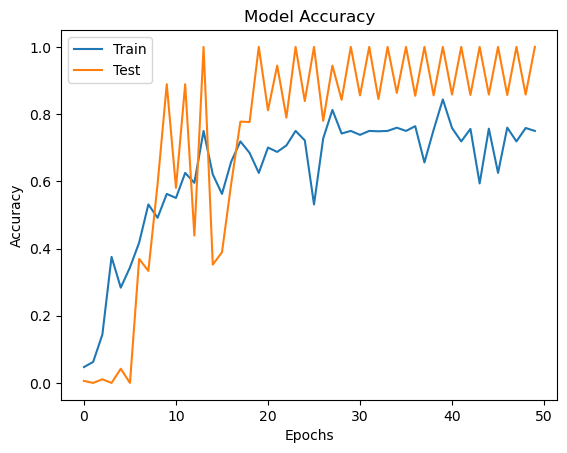

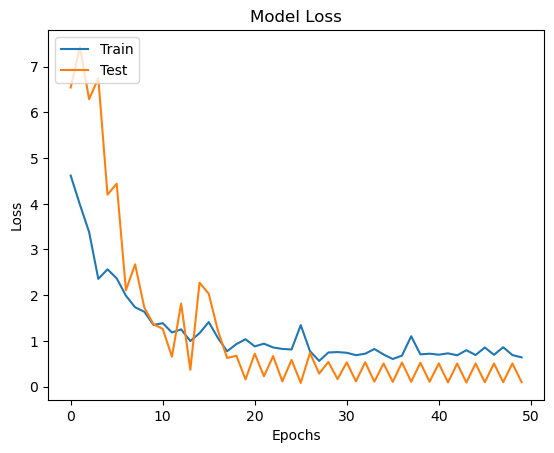

In [19]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [20]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_accuracy:.4f}')


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7225 - loss: 0.9500
Test accuracy: 0.7272
